# Human Action Recognition using Pretrained Networks and Transfer Learning

We classify the human action using 2 different base models with transfer learning:
* ResNet v2
* VGG16


In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [2]:
FINE_TUNING_EPOCHS = 12 
TRAINING_EPOCHS = 5
BATCH_SIZE = 32

image_height = 180 
image_width = 300

# Load data

In [3]:

# Load data
test_df     = pd.read_csv("Testing_set.csv")
training_df = pd.read_csv("Training_set.csv")

In [4]:
# Stratified Sampling
valid_df = training_df.groupby('label').apply(lambda x: x.sample(frac=0.10))
valid_df = valid_df.droplevel(0)
train_df = training_df.drop(valid_df.index)

C:\Users\sskam\AppData\Local\Temp\ipykernel_16272\63394298.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  valid_df = training_df.groupby('label').apply(lambda x: x.sample(frac=0.10))


In [10]:
training_df.head()

filename         label
0  Image_1.jpg       sitting
1  Image_2.jpg  using_laptop
2  Image_3.jpg       hugging
3  Image_4.jpg      sleeping
4  Image_5.jpg  using_laptop

In [11]:
freq = training_df['label'].value_counts()
train_freq = train_df['label'].value_counts()
valid_freq = valid_df['label'].value_counts()

print(freq,"\n\n", train_freq,"\n\n",valid_freq)
print()

label
sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: count, dtype: int64 

 label
sitting               756
using_laptop          756
hugging               756
sleeping              756
drinking              756
clapping              756
dancing               756
cycling               756
calling               756
laughing              756
eating                756
fighting              756
listening_to_music    756
running               756
texting               756
Name: count, dtype: int64 

 label
calling               84
clapping              84
cycling               84
dancing               84
drinking              84
eating             

In [12]:
test_df.head()

filename
0  Image_1.jpg
1  Image_2.jpg
2  Image_3.jpg
3  Image_4.jpg
4  Image_5.jpg

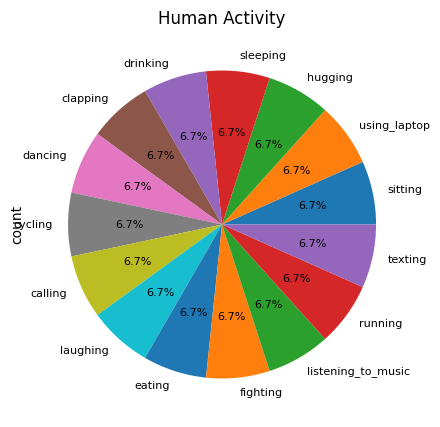

In [13]:
freq.plot(kind='pie',figsize=(5,5),title='Human Activity',autopct='%1.1f%%',shadow = False,  fontsize=8);

# Data Generators

In [14]:
# deep learning libraries
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

train_df = pd.read_csv("Training_set.csv")
image_height, image_width = 224, 224
BATCH_SIZE = 32

gen = ImageDataGenerator(rescale=1./255.,
                         horizontal_flip=True,
                         vertical_flip=False,
                         zoom_range=0.05,
                         rotation_range=25)

train_generator = gen.flow_from_dataframe(
    train_df, 
    directory="train/",  
    x_col='filename',
    y_col='label',
    color_mode="rgb",
    target_size=(image_height, image_width),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)


Found 12600 validated image filenames belonging to 15 classes.


In [16]:
test_gen = ImageDataGenerator(rescale = 1./255.)

validation_generator = test_gen.flow_from_dataframe(
    valid_df, 
    directory   = "train/", 
    x_col       = 'filename',
    y_col       = 'label',
    color_mode  ="rgb",
    target_size = (image_height, image_width),
    class_mode  = "categorical",
    batch_size  = BATCH_SIZE,
    shuffle     = False,
    seed        = 42)

test_generator = test_gen.flow_from_dataframe(
    test_df, 
    directory   ="test/", 
    x_col       = 'filename',
    #y_col       = 'labels',
    color_mode  = "rgb",
    target_size = (image_height, image_width), 
    class_mode = None,
    batch_size  = BATCH_SIZE,
    shuffle  = False)

Found 1260 validated image filenames belonging to 15 classes.


Found 5400 validated image filenames.


In [17]:
a = train_generator.class_indices
class_names = list(a.keys())  # storing class/breed names in a list

In [18]:
class_names

['calling',
 'clapping',
 'cycling',
 'dancing',
 'drinking',
 'eating',
 'fighting',
 'hugging',
 'laughing',
 'listening_to_music',
 'running',
 'sitting',
 'sleeping',
 'texting',
 'using_laptop']

In [19]:
import matplotlib.pyplot as plt

def plot_images(img, true_labels, predictions = None):
    plt.figure(figsize=[12, 18])
    for i in range(24):
        plt.subplot(6, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if (predictions is not None):
            if true_labels is not None:
                plt.title("{}\n {} {:.1f}%".format(class_names[np.argmax(true_labels[i])], class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i])))
            else:
                plt.title("{} {:.1f}%".format(class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i]))) 
        else:
            if true_labels is not None:
                plt.title(class_names[np.argmax(true_labels[i])])    

# Sample Images

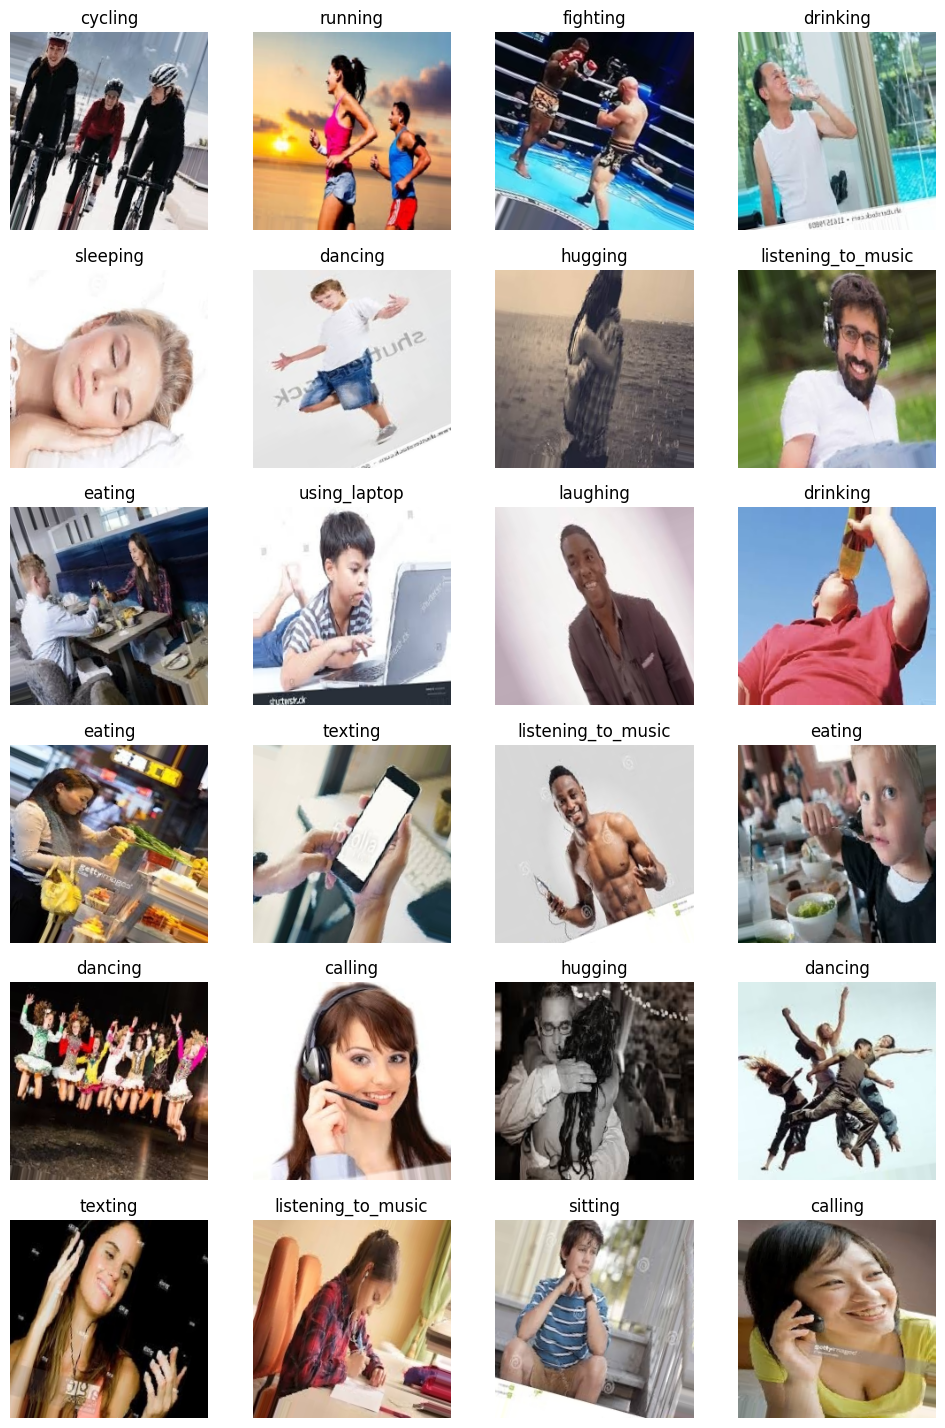

In [20]:
x,y = next(train_generator)
plot_images(x,y)

In [21]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax)
    ax.set_title(title, fontsize = 12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
    ax.set_ylabel('True Label', fontsize= 10)
    ax.set_xlabel('Predicted Label', fontsize = 10)

# Model

In [24]:
from tensorflow.keras.models import Model

def create_model(base_model):
    
    x = base_model.output    
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    
    outputs = Dense(len(class_names), activation='softmax')(x)
    
    model = Model(base_model.inputs, outputs)
    
    return model  

In [26]:
def fit_model(model, base_model, epochs, fine_tune = 0):
    
    early = tf.keras.callbacks.EarlyStopping( patience = 10,
                                              min_delta = 0.001,
                                              restore_best_weights = True)

    
    print("Unfreezing number of layers in base model = ", fine_tune)
    
    if fine_tune > 0:
        base_model.trainable = True
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False       
        # small learning rate for fine tuning
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        base_model.trainable = False
        model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
       

    history = model.fit(train_generator,
                        validation_data = validation_generator,
                        epochs = epochs,
                        callbacks = [early])
    
    return history

# Inception ResNetV2

In [30]:

inception_base_model = tf.keras.applications.InceptionResNetV2(
                     include_top = False,
                     weights = 'imagenet',
                     input_shape = (image_height, image_width, 3)
                     )
inception_model = create_model(inception_base_model)
history = fit_model(inception_model, inception_base_model, epochs = TRAINING_EPOCHS)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 442s 2us/step
Unfreezing number of layers in base model =  0
Epoch 1/5


c:\Users\sskam\anaconda3\envs\nnm22am024\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


394/394 ━━━━━━━━━━━━━━━━━━━━ 1107s 3s/step - accuracy: 0.2673 - loss: 2.3219 - val_accuracy: 0.5603 - val_loss: 1.3435
Epoch 2/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 1079s 3s/step - accuracy: 0.4669 - loss: 1.6629 - val_accuracy: 0.6238 - val_loss: 1.2494
Epoch 3/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 1107s 3s/step - accuracy: 0.5234 - loss: 1.5193 - val_accuracy: 0.6476 - val_loss: 1.1588
Epoch 4/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 1207s 3s/step - accuracy: 0.5462 - loss: 1.4409 - val_accuracy: 0.6405 - val_loss: 1.1349
Epoch 5/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 1317s 3s/step - accuracy: 0.5517 - loss: 1.4189 - val_accuracy: 0.6603 - val_loss: 1.1285


In [31]:
inception_base_model.save('inceptionsave1.h5') 

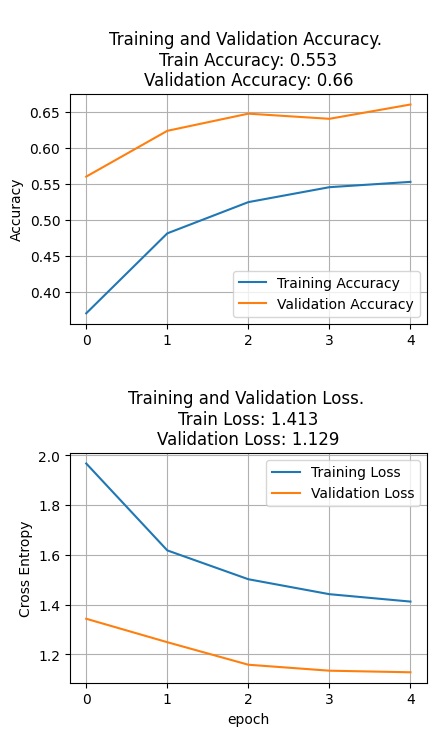

In [32]:
plot_history(history)

In [33]:
accuracy_score = inception_model.evaluate(validation_generator)

print(accuracy_score)
print("Accuracy: {:.2f}%".format(accuracy_score[1] * 100))
print("Loss: {:.3f}".format(accuracy_score[0]))

40/40 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.6686 - loss: 1.1304
[1.128515362739563, 0.6603174805641174]
Accuracy: 66.03%
Loss: 1.129


In [34]:
validation_generator.reset()
inception_val_preds = inception_model.predict(validation_generator)
inception_val_pred_classes = np.argmax(inception_val_preds, axis=1)

40/40 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step


In [35]:
test_generator.reset()
inception_test_preds = inception_model.predict(test_generator)
inception_test_pred_classes = np.argmax(inception_test_preds, axis=1)

169/169 ━━━━━━━━━━━━━━━━━━━━ 531s 3s/step


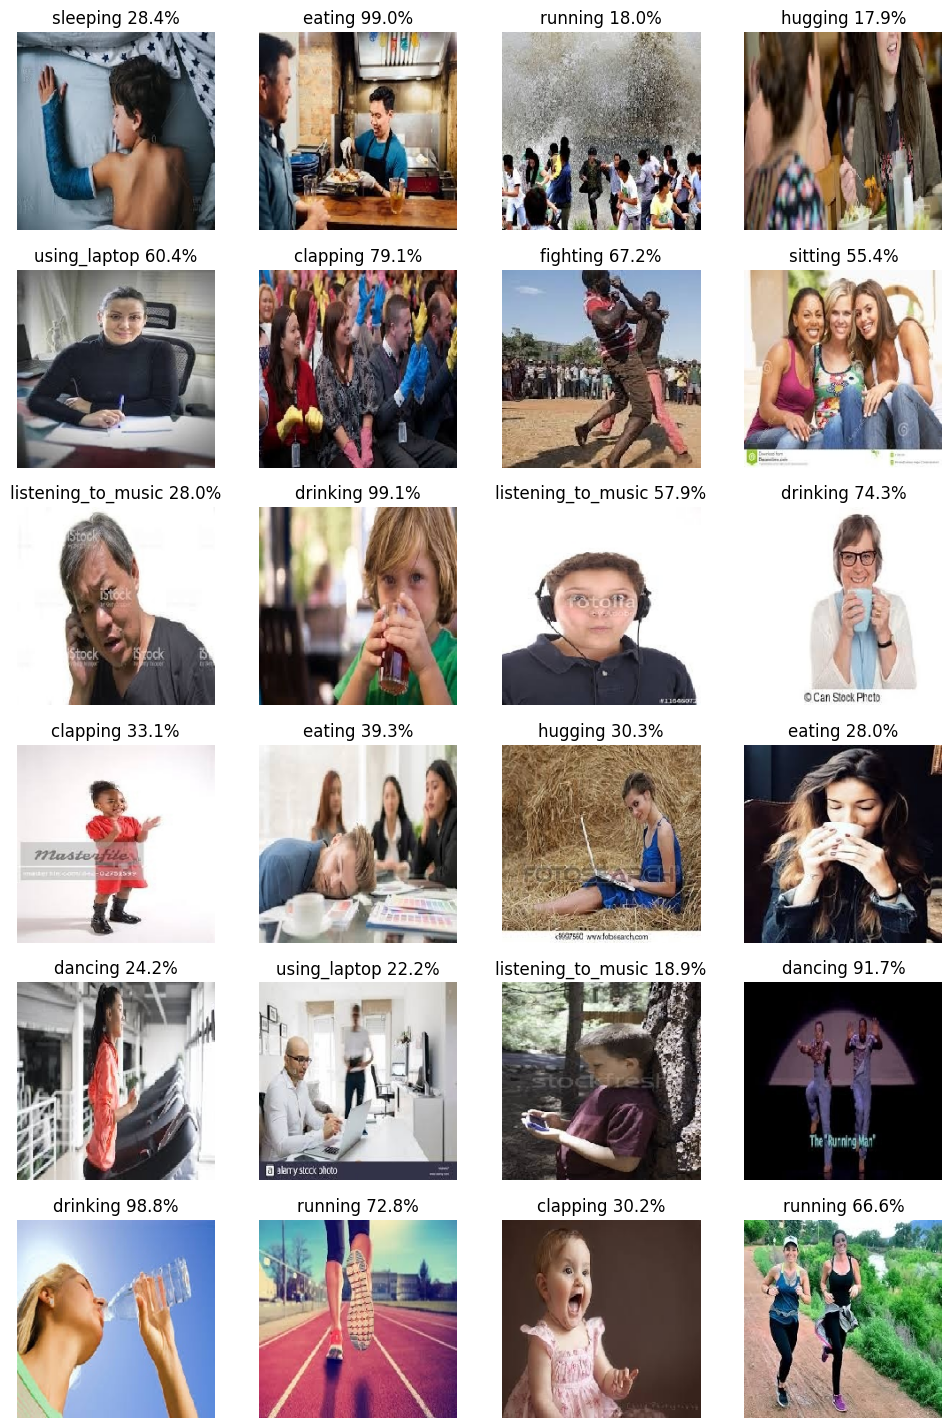

In [36]:
test_generator.reset()
x = next(test_generator)
plot_images(x, None, inception_test_preds)

# VGG16

In [27]:
vgg16_base_model = tf.keras.applications.vgg16.VGG16(
                             include_top = False,
                             weights = 'imagenet',
                             input_shape = (image_height, image_width, 3)
                             )
vgg16_model = create_model(vgg16_base_model)
history = fit_model(vgg16_model, vgg16_base_model, epochs = TRAINING_EPOCHS)

Unfreezing number of layers in base model =  0
Epoch 1/5


c:\Users\sskam\anaconda3\envs\nnm22am024\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


394/394 ━━━━━━━━━━━━━━━━━━━━ 1538s 4s/step - accuracy: 0.1394 - loss: 2.6013 - val_accuracy: 0.3468 - val_loss: 1.9930
Epoch 2/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 1525s 4s/step - accuracy: 0.2973 - loss: 2.0811 - val_accuracy: 0.4159 - val_loss: 1.7766
Epoch 3/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 1418s 4s/step - accuracy: 0.3416 - loss: 1.9603 - val_accuracy: 0.4325 - val_loss: 1.7392
Epoch 4/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 1457s 4s/step - accuracy: 0.3836 - loss: 1.8799 - val_accuracy: 0.4698 - val_loss: 1.6358
Epoch 5/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 1415s 4s/step - accuracy: 0.4026 - loss: 1.8125 - val_accuracy: 0.4810 - val_loss: 1.6570


In [28]:
vgg16_base_model.save('vggsave2.h5') 

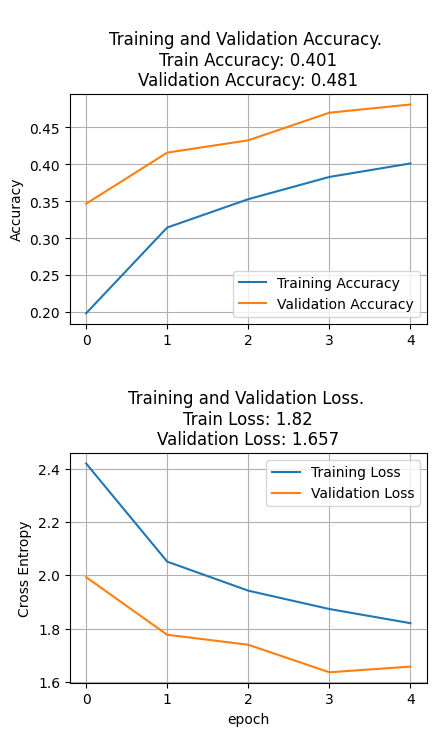

In [29]:
plot_history(history)

In [30]:
accuracy_score = vgg16_model.evaluate(validation_generator)

print(accuracy_score)
print("Accuracy: {:.2f}%".format(accuracy_score[1] * 100))
print("Loss: {:.3f}".format(accuracy_score[0]))

40/40 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.4306 - loss: 1.6796
[1.635780930519104, 0.46984127163887024]
Accuracy: 46.98%
Loss: 1.636


In [31]:
validation_generator.reset()

vgg16_val_preds = vgg16_model.predict(validation_generator)
vgg16_val_pred_classes = np.argmax(vgg16_val_preds, axis=1)

40/40 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step


In [32]:
test_generator.reset()

vgg16_test_preds = vgg16_model.predict(test_generator)
vgg16_test_pred_classes = np.argmax(vgg16_test_preds, axis=1)

169/169 ━━━━━━━━━━━━━━━━━━━━ 550s 3s/step


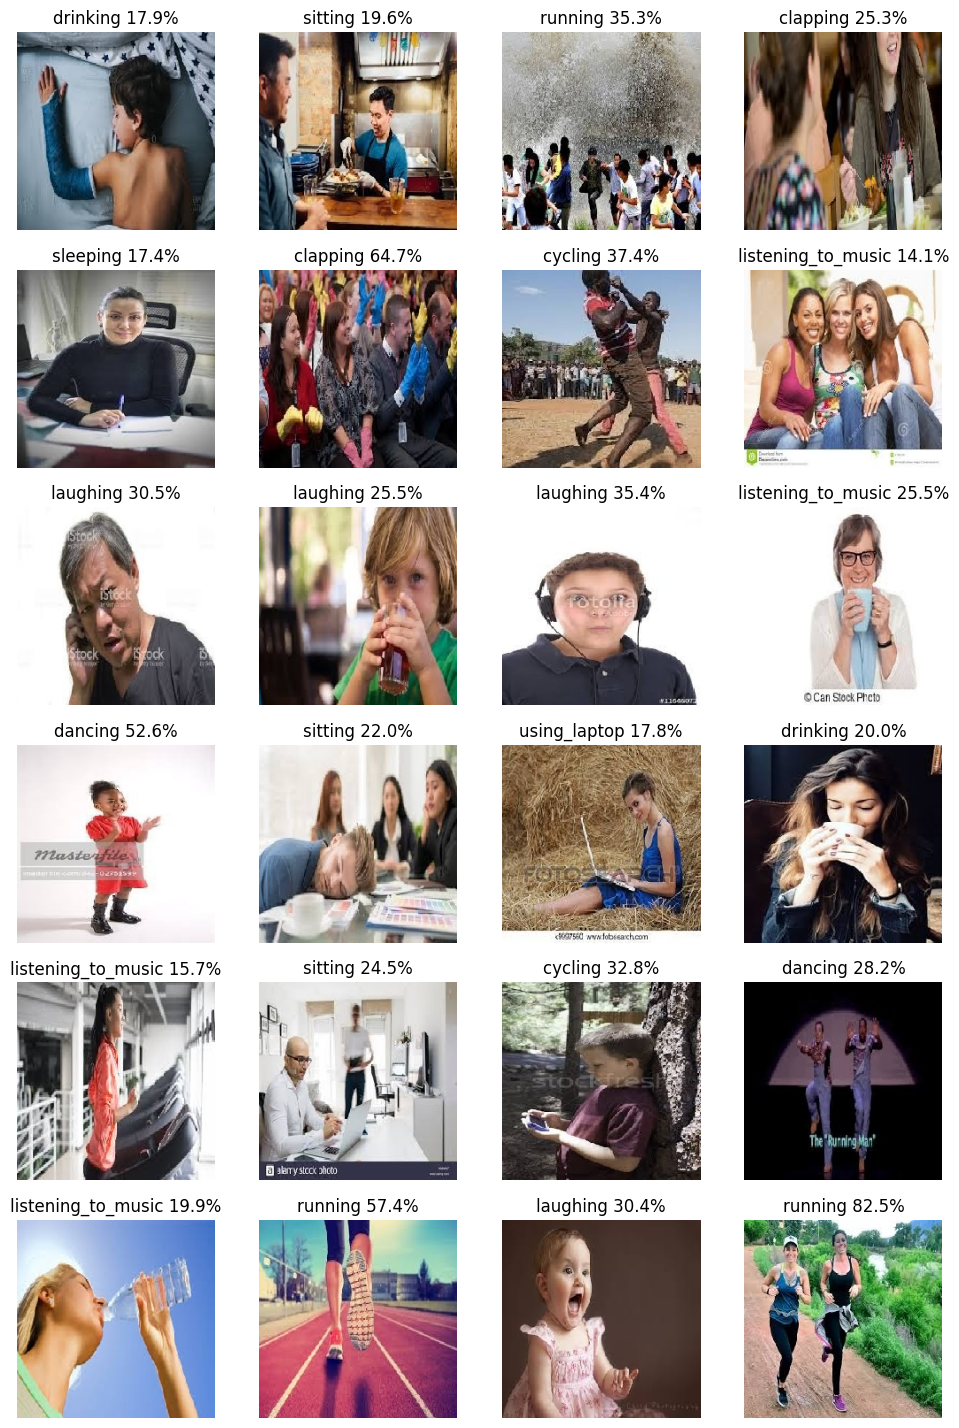

In [33]:
test_generator.reset()
x = next(test_generator)
plot_images(x, None, vgg16_test_preds)